In [1]:
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

pd.set_option('display.max_columns',None)

pd.set_option('display.max_rows',None)


import warnings
warnings.filterwarnings('ignore')

import models

import time

from plotnine import *

In [2]:
#load mnist dataset from tf library
mnist = tf.keras.datasets.mnist
#get train and test data of mnist digits
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
#exctract only 0 and 1 form digits dataset
train_images = np.logical_or((y_train == 0), (y_train == 1))
test_images = np.logical_or((y_test == 0), (y_test == 1))
x_train, y_train = x_train[train_images], y_train[train_images]
x_test, y_test = x_test[test_images], y_test[test_images]

In [4]:
#split training set to ones and zeros to plot their images in seperate rows
ones_train = x_train[y_train == 1]
zeros_train = x_train[y_train == 0]

**12.**
Let's draw 3 images of samples labeled with ’0’ and 3 images of samples labeled with ’1’.

In [5]:
# Q 12
def plot_images(N):
    """
    this function get n samples and plot n images from each label
    :param N: number of samples from each label
    """
    fig, axes = plt.subplots(2, N, sharex=True, sharey=True) #create subplots
    for i, ax in enumerate(axes.flatten()): 
        if i >= N: # if image is in the second row
            ax.imshow(zeros_train[i])
        else:
            ax.imshow(ones_train[i])

    plt.suptitle("Drawing {} samples from data".format(N)) #add super title
    plt.show()

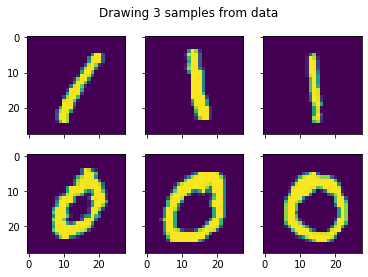

In [6]:
#plot 3 images from each label
plot_images(3)

In [7]:
# Q 13
def rearrange_data(X):
    """
    :param X: matrix from size m x N x N
    :return: matrix from shape m x N^2
    """
    m = X.shape[0]
    return X.reshape(m, -1)

In [8]:
def draw_m_random_points(m, X, y):
    """
    :param m: number of observations we draw
    :param X: train matrix X from shape q x N x N
    :param y: np vector from size q x 1    
    :return: X_train_m - reshaped matrix (size m X N^2) of random choice from X
             y_train_m - random choice from y (matched to X_train_m)
    """
    #get random selection of indices without return
    rand = np.random.choice(len(y), m, replace=False)
    
    #slice data by random indices
    X_train_m, y_train_m = X[rand], y[rand]
    
    #check if we have at least one observation from each label
    while (y_train_m == 0).sum() == 0 or (y_train_m == 1).sum() == 0:
        rand = np.random.choice(len(y), 3, replace=False)
        X_train_m, y_train_m = X[rand], y[rand]
    
    #rearranging X random data
    X_train_m = rearrange_data(X_train_m)
    
    return X_train_m, y_train_m

In [9]:
#create classifier objects
logistic, svm, tree, knn = LogisticRegression(), SVC(C=1/10, kernel='linear'), DecisionTreeClassifier(max_depth=15), KNeighborsClassifier(n_neighbors=15)

#create classifiers array
classifiers = [logistic, svm, tree, knn]

#create classifiers names array
names = ["Logistic", "SVM", "TREE", "KNN"]

In [10]:
#reshape X_test data
X_test = rearrange_data(x_test)

In [11]:
def classifier_score(c, ITER, X_train, y_train, m, X_test,y_test, name):
    """
    This function compute the mean accuracy for a classifier c for ITER iterations
    :param m: number of observations we draw on each iteration
    :param X_train: Train matrix X
    :param y_train: Training labels vector y
    :param X_test: Test matrix X
    :param y_test: Test labels vector y
    :return: mean accuracy of the classifier
    """
    acc_lst = []
    fit_time_lst = []
    score_time_lst = []
    
    for i in tqdm(range(ITER)):
        X_train_m, y_train_m = draw_m_random_points(m, X_train,y_train)
        s_fit = time.time()
        c.fit(X_train_m,y_train_m)
        end_fit = time.time()
        s_score = time.time()
        acc = c.score(X_test, y_test)
        end_score = time.time()
        fit_time = (end_fit-s_fit)
        score_time = (end_score-s_score)   

        acc_lst.append(acc)
        fit_time_lst.append(fit_time)
        score_time_lst.append(score_time)
    
    return round(np.mean(acc_lst),3), round(np.mean(fit_time_lst),3), round(np.mean(score_time_lst),3)

In [ ]:
# list of m sizes of training set
M = [50,100,300,500]
# create the final scores dict, later will be used to created dataframe.
final_dict = {}
fit_times = {}
score_times = {}
# set number of iterations
ITER = 50

#create a scoring dictionary for each m and each classifier
for m in M:
    classifier_dict = {}
    fit_time_dict = {}
    score_time_dict = {}
    for c in range(len(classifiers)):
        score, fit_time, score_time = classifier_score(classifiers[c], ITER, x_train, y_train, m, X_test, y_test, name=names[c])
        classifier_dict[names[c]] = score
        fit_time_dict[names[c]] = fit_time
        score_time_dict[names[c]] = score_time

    final_dict[m] = classifier_dict
    fit_times[m] = fit_time_dict
    score_times[m] = score_time_dict

In [13]:
#create a dataframe of our results
df = pd.DataFrame(final_dict)
df_fit = pd.DataFrame(fit_times)
df_score = pd.DataFrame(score_times)
df_score['type'] = "Prediction"
df_fit['type'] = "Training"

In [14]:
df_times = pd.concat([df_fit, df_score]).reset_index().melt(id_vars=['index', 'type'])

In [15]:
#melt dataframe for easy plotting
melted = df.reset_index().melt(id_vars=['index'])

**14.**
Similarly to question 10, we will test the accuracy of the various classifiers. This time we will also check their running time.

After a long though, I chose to use the classifiers from SCIKIT-LEARN. I chose them mainly for two reasons: 1. their running time considered good, so the time comparison will be as pure as possible. 2. Their documentation is great, so I could read about each parameter and decide which values to use and how.

I chose to give the soft-SVM te parameter c=10, which I thougt wasn't too big or small.
I also chose maximum tree depth to be 15 and k-nearest-neighbours to be 15. I tried few times with same random seed and decided that these values are giving me the best results due the bias-variance tradoff and the sizes of the training and test set.

The results are here:

**Accuracy Comparison**
First, We can see that the lowest Accuracy of 50 samples was 0.95. I believe that means that all of our models did pretty good!
We can also see that in a small mumber of samples, the KNN was a bit far behind, but makes a huge improvement as the Training set gets bigger. 

The main idea that the graph shows that the accuracy in every model increases with the number of samples. In the KNN and the DesicionTree classifiers, we can see that the sample size is very important for the success of the prediction. 
When you think about it, it makes a lot of sense since the boundaries get more and more "smooth" and the desicion rule is getting more generalized for bigger train data.

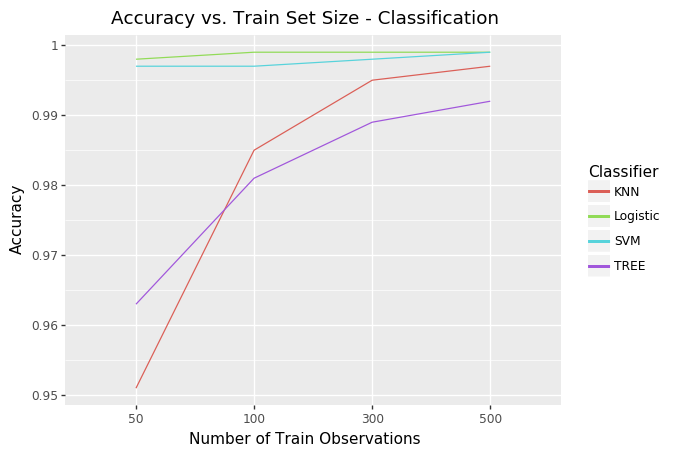

In [16]:
#plot results
(ggplot(melted) + geom_line(aes(x='variable',y='value',color='index', group='index')) 
 + labs(x='Number of Train Observations', y='Accuracy', title='Accuracy vs. Train Set Size - Classification') 
 + scale_color_discrete(name='Classifier')).draw();

**Time Comparison**

I decided to split this plot into two subplots:
The time in both figures is the average time over all iterations.

The top figure represents a comparison between The various models and the time took each one to make the prediction.
We can see that even with large amount of data, besides KNN all the classifiers prediction work very fast.
If we think about the causes for it, we can remember that in every prediction, all of the faster classifiers (Logistic, SVM, Tree) just get a point and returns a label by a prediction rule, while KNN classifier calculates the distance to all the other points, means that as bigger is our training set, as slower is our prediction

The bottom figure presents the training time. We can see that SVM classifier is the slower one from all, and that the KNN and the Logistic Regression classifiers are slightly better then the others. 

The parameters I chose affect the running time. After many checks I got to the conclusion that SVM for example has higher fitting time as C get smaller (means that "harder" svm learns the data slower, and the opposite).

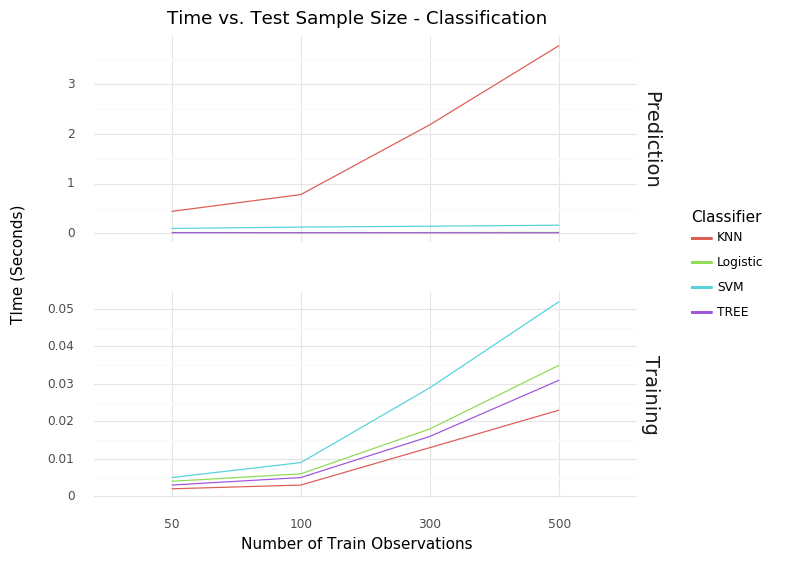

In [17]:
(ggplot(df_times) + geom_line(aes(x='variable',y='value',color='index', group='index')) + facet_grid("type~", scales='free_y')
 + labs(x='Number of Train Observations', y='TIme (Seconds)', title='Time vs. Test Sample Size - Classification') 
 + scale_color_discrete(name='Classifier') + theme_minimal() 
 + theme(figure_size=(7,6), 
         axis_title_y = element_text(margin={'r': 30}),
        strip_text_y = element_text(size = 14),
        panel_spacing=.5)).draw();